In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
# üìò 03_visualizing.ipynb
# Nhi·ªám v·ª•: Tr·ª±c quan d·ªØ li·ªáu ECG, attention map v√† Grad-CAM

import os, sys
sys.path.append("../")

import torch
import numpy as np
import matplotlib.pyplot as plt

from visualize.plot_signals import load_ecg_mat, plot_ecg_signals, plot_spectrogram, plot_compare
from visualize.plot_statistics import analyze_top_diseases
from visualize.attention_map import get_attention_weights, plot_attention_dots
from visualize.generate_attention_maps import generate_attention_visualizations
from visualize.gradcam import visualize_gradcam_multilabel

from training.model_resnet50 import ResNet1D50Attention
from training.model import ResNet1DAttention
from training.dataset_loader import ECGDataset

# **EDA ECG**

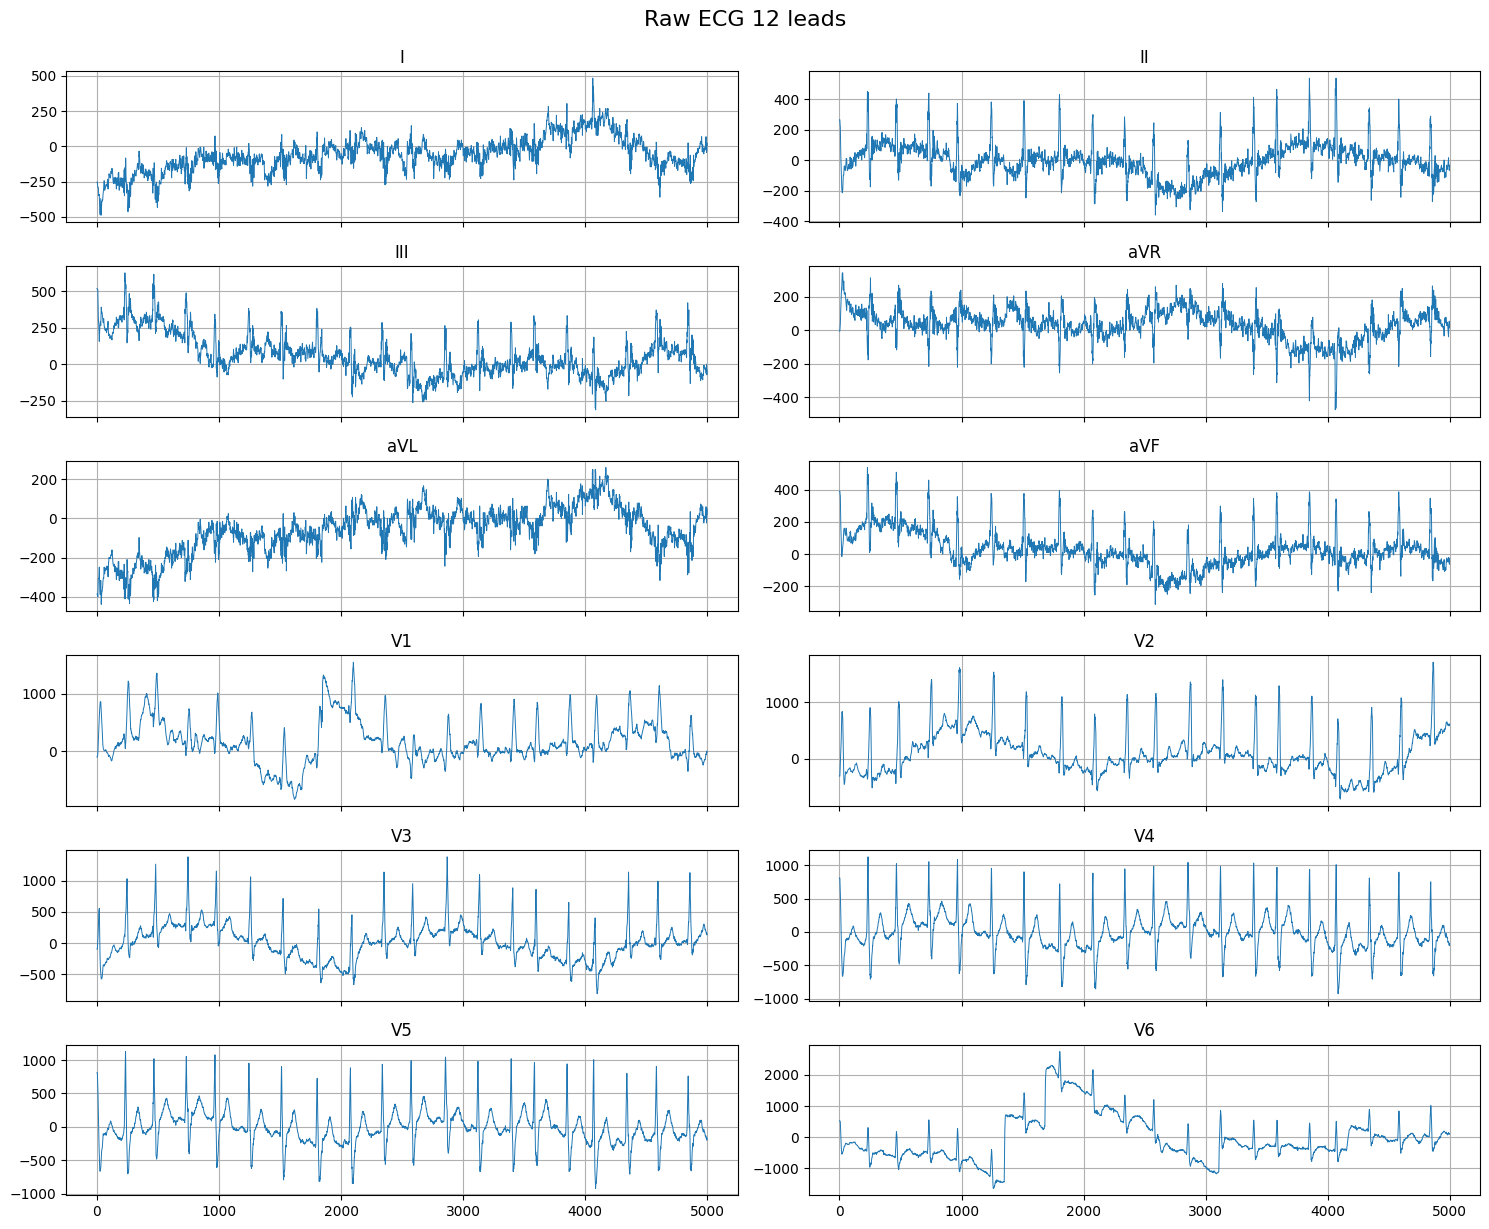

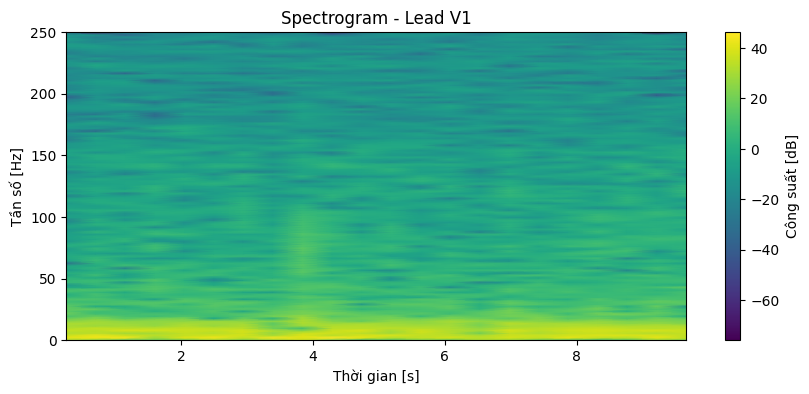

In [3]:
# === Hi·ªÉn th·ªã t√≠n hi·ªáu ECG ===

mat_path = r"E:\NCKH - 2026\ECG Project\data\raw\WFDBRecords\01\010\JS00001.mat"
signals = load_ecg_mat(mat_path)

# Plot 12 ƒë·∫°o tr√¨nh
plot_ecg_signals(signals, title="Raw ECG 12 leads")

# Plot spectrogram c·ªßa ƒë·∫°o tr√¨nh V2
plot_spectrogram(signals, fs=500, lead_index=6)

         Code  Count Disease_Name  Percentage
0   426177001  16542           SB   18.936740
1   164890007   8010           AF    9.169586
2   426783006   7962           SR    9.114637
3   427084000   7244           ST    8.292694
4   164934002   7006          TWC    8.020239
5    55827005   5378      Unknown    6.156558
6    55930002   4172      Unknown    4.775969
7    59931005   2866          TWO    3.280903
8   427393009   2546           SA    2.914577
9   164889003   1780         AFIB    2.037686
10  429622005   1665         STDD    1.906038
11   39732003   1537          ALS    1.759507
12  284470004   1299          APB    1.487053
13   10370003   1180      Unknown    1.350825
14  428750005   1158         STTC    1.325640


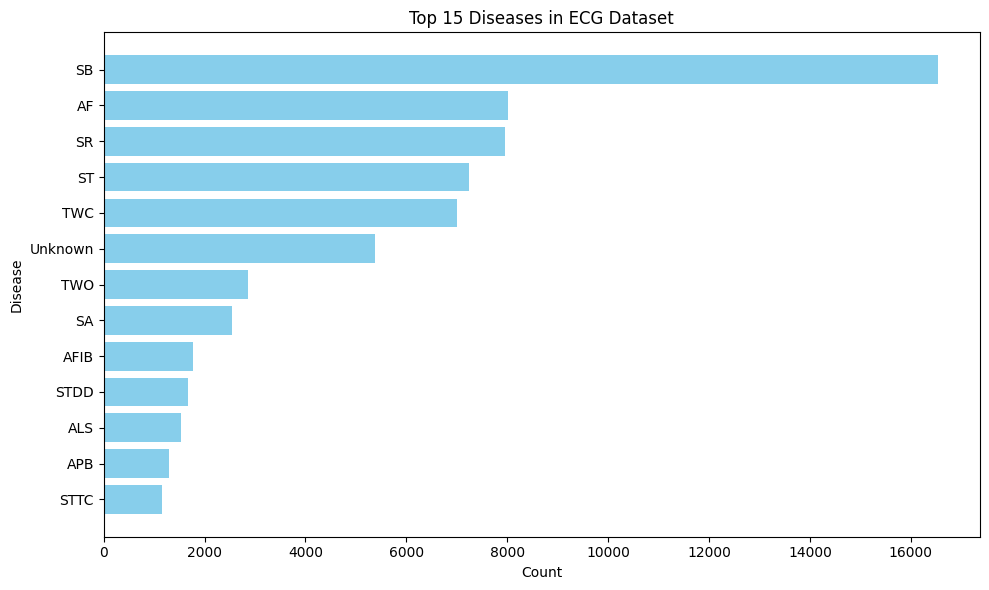

In [6]:
# === Ph√¢n t√≠ch t·∫ßn su·∫•t b·ªánh top N ===
metadata_path = r"E:\NCKH - 2026\ECG Project\data\processed\patient_metadata_clean.xlsx"
snomed_path = r"E:\NCKH - 2026\ECG Project\data\raw\ConditionNames_SNOMED-CT.csv"

analyze_top_diseases(metadata_path, snomed_path, top_n=15)

# **ATTENTION**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8684\1291112365.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

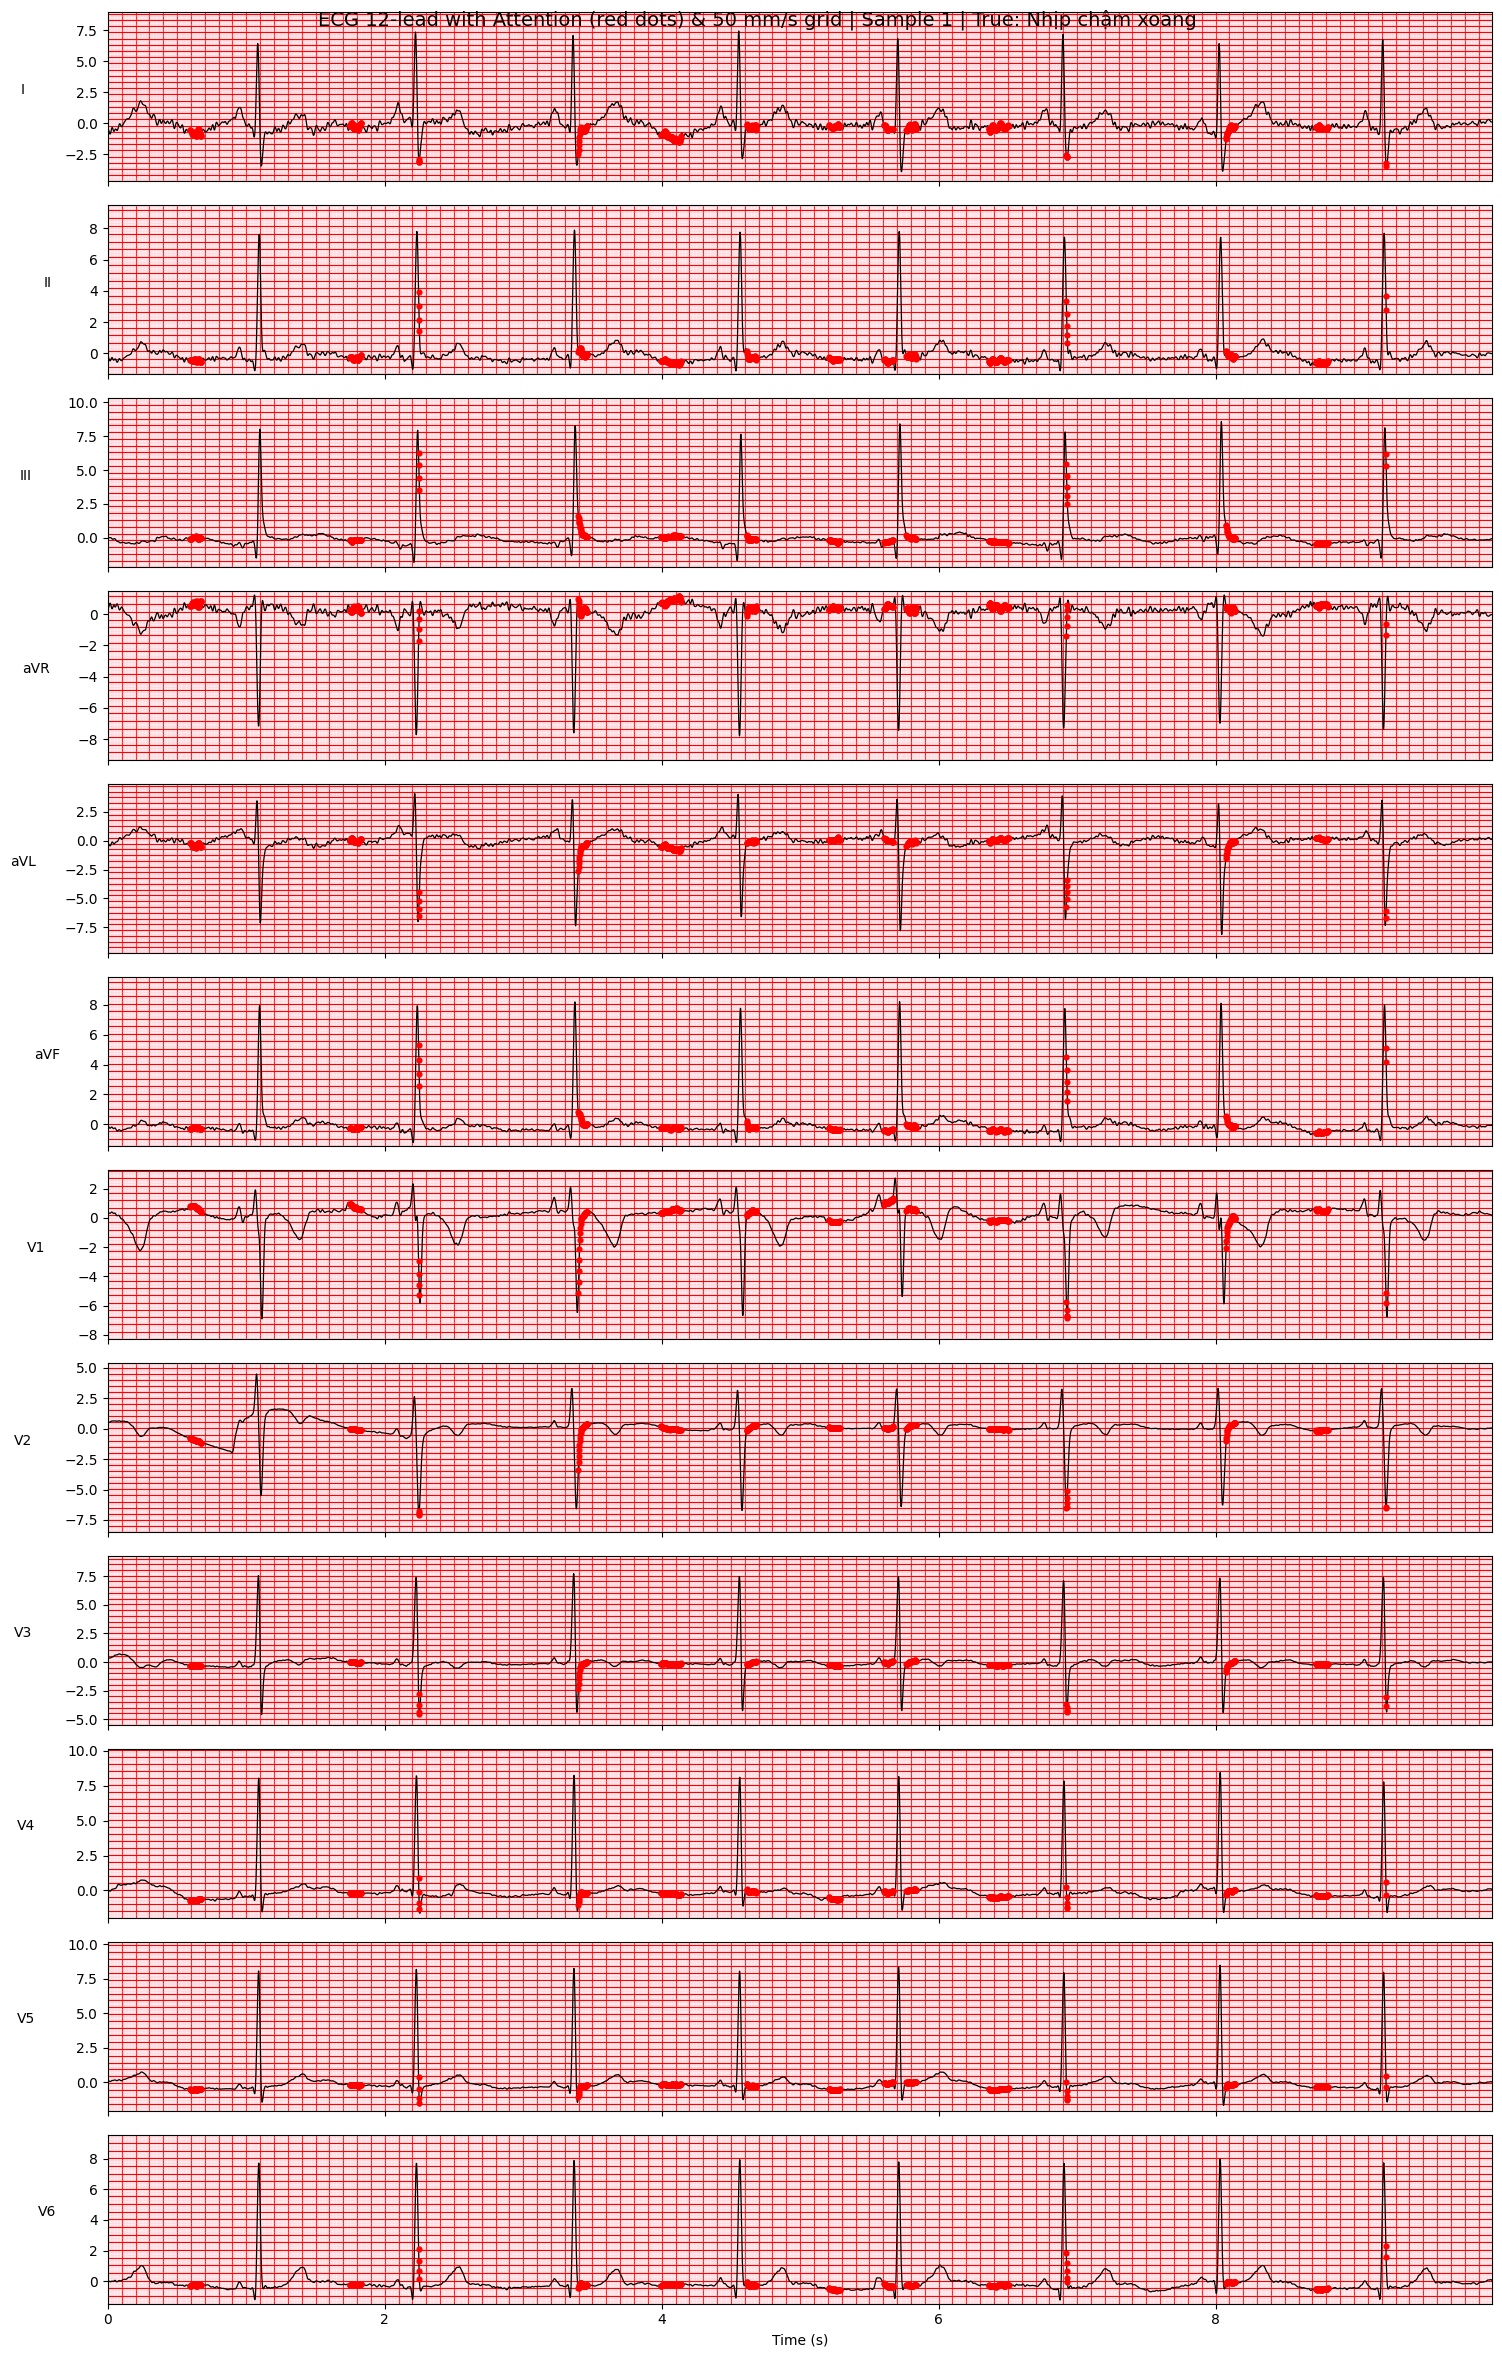

In [2]:
# === Attention Map (m√¥ h√¨nh ResNet1D + Attention) ===

# Load m√¥ h√¨nh
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r"E:\NCKH - 2026\ECG Project\models\final_fine_tuned_modelres50.pth"

model = ResNet1D50Attention(num_classes=8).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load 1 m·∫´u t√≠n hi·ªáu test
sample_file = r"E:\NCKH - 2026\ECG Project\data\processed\ecg_npy\record_1.npy"
signal = torch.tensor(np.load(sample_file), dtype=torch.float32)

# L·∫•y tr·ªçng s·ªë attention
attn_weights = get_attention_weights(model, signal)

# V·∫Ω b·∫£n ƒë·ªì ch√∫ √Ω
plot_attention_dots(signal, attn_weights, sample_idx=1, label_true="Nh·ªãp ch·∫≠m xoang")

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from visualize.attention_map import plot_attention_dots  # h√†m v·∫Ω attention

# === C·∫•u h√¨nh ===
base_dir = r"E:\NCKH - 2026\ECG Project"
splits_dir = os.path.join(base_dir, "data", "processed", "splits")
npy_dir = os.path.join(base_dir, "data", "processed", "ecg_npy")
output_root = os.path.join(base_dir, "data", "processed", "attention_visualize_test")

label_map = {
    "426177001": "Nh·ªãp ch·∫≠m xoang",
    "426783006": "Nh·ªãp xoang b√¨nh th∆∞·ªùng",
    "164890007": "Cu·ªìng nhƒ©",
    "427084000": "Ch√™nh l√™n ƒëo·∫°n ST",
    "427393009": "Lo·∫°n nh·ªãp xoang",
    "164889003": "Rung nhƒ©",
    "429622005": "Ch√™nh xu·ªëng ƒëo·∫°n ST",
    "39732003": "Tr·ª•c ƒëi·ªán tim l·ªách tr√°i",
}

# === Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1D50Attention(num_classes=8).to(device)

# ‚ö†Ô∏è D√πng weights_only=True ƒë·ªÉ tr√°nh c·∫£nh b√°o b·∫£o m·∫≠t
model.load_state_dict(torch.load(
    os.path.join(base_dir, "models", "final_fine_tuned_modelres50.pth"),
    map_location=device,
    weights_only=True
))
model.eval()

# === L·∫•y 1 file ƒë·∫ßu ti√™n trong t·∫≠p train ===
train_files = np.load(os.path.join(splits_dir, "train_files.npy"), allow_pickle=True)
y_train = np.load(os.path.join(splits_dir, "y_train.npy"), allow_pickle=True)

file_name = train_files[0]
y_value = y_train[0]

# --- N·∫øu nh√£n l√† one-hot ---
if isinstance(y_value, (np.ndarray, list)) and len(y_value) == 8:
    label_idx = int(np.argmax(y_value))
    label_code = list(label_map.keys())[label_idx]
# --- N·∫øu nh√£n l√† string ---
else:
    label_code = str(y_value)

label_name = label_map.get(label_code, "Unknown")

print(f"‚û°Ô∏è Test file: {file_name}")
print(f"‚û°Ô∏è Nh√£n: {label_name} ({label_code})")

# === Load t√≠n hi·ªáu ECG ===
file_path = os.path.join(npy_dir, file_name)
signal = torch.tensor(np.load(file_path), dtype=torch.float32)

# === Hook l·∫•y attention ===
attention_weights = {}

def hook_fn(module, input, output):
    if isinstance(output, tuple) and len(output) > 1:
        attention_weights["value"] = output[1].detach().cpu()

handle = model.attention.register_forward_hook(hook_fn)
with torch.no_grad():
    _ = model(signal.unsqueeze(0).to(device))
handle.remove()

# === Chu·∫©n h√≥a attention ===
attn_weights = attention_weights.get("value", torch.zeros(signal.shape[1]))
attn_weights = attn_weights.squeeze().numpy()
attn_weights = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min() + 1e-9)

# === V·∫Ω v√† l∆∞u ===
fig = plot_attention_dots(signal=signal, attn_weights=attn_weights, threshold=0.9)

# --- L∆∞u ƒë√∫ng th∆∞ m·ª•c ---
output_dir = os.path.join(output_root, label_name)
os.makedirs(output_dir, exist_ok=True)

save_path = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(file_name))[0]}.png")

fig.savefig(save_path, dpi=150, bbox_inches="tight")
plt.close(fig)

print(f"‚úÖ ·∫¢nh ƒë√£ l∆∞u t·∫°i: {save_path}")

‚û°Ô∏è Test file: E:\NCKH - 2026\ECG Project\notebooks\..\data\processed\ecg_npy\record_5599.npy
‚û°Ô∏è Nh√£n: Nh·ªãp xoang b√¨nh th∆∞·ªùng (426783006)
‚úÖ ·∫¢nh ƒë√£ l∆∞u t·∫°i: E:\NCKH - 2026\ECG Project\data\processed\attention_visualize_test\Nh·ªãp xoang b√¨nh th∆∞·ªùng\record_5599.png


In [ ]:
# === ƒê∆∞·ªùng d·∫´n ch√≠nh ===
base_dir = r"E:\NCKH - 2026\ECG Project"
splits_dir = os.path.join(base_dir, "data", "processed", "splits")
npy_dir = os.path.join(base_dir, "data", "processed", "ecg_npy")
output_dir = os.path.join(base_dir, "data", "processed", "attention_visualize")

# === B·∫£n ƒë·ªì nh√£n (8 l·ªõp) ===
label_map = {
    "426177001": "Nh·ªãp ch·∫≠m xoang",
    "426783006": "Nh·ªãp xoang b√¨nh th∆∞·ªùng",
    "164890007": "Cu·ªìng nhƒ©",
    "427084000": "Ch√™nh l√™n ƒëo·∫°n ST",
    "427393009": "Lo·∫°n nh·ªãp xoang",
    "164889003": "Rung nhƒ©",
    "429622005": "Ch√™nh xu·ªëng ƒëo·∫°n ST",
    "39732003": "Tr·ª•c ƒëi·ªán tim l·ªách tr√°i",
}

# === Load m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = os.path.join(base_dir, "models", "final_fine_tuned_modelres50.pth")

model = ResNet1D50Attention(num_classes=len(label_map)).to(device)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()

# === Sinh ·∫£nh Attention ===
generate_attention_visualizations(
    model=model,
    train_files_path=os.path.join(splits_dir, "train_files.npy"),
    y_train_path=os.path.join(splits_dir, "y_train.npy"),
    ecg_npy_dir=npy_dir,
    output_root=output_dir,
    label_map=label_map,
    device=device
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20660\2970450678.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path, map_location=device)


T·ªïng s·ªë m·∫´u: 31393


Generating Attention:   0%|                                                      | 23/31393 [03:07<69:14:42,  7.95s/it]E:\NCKH - 2026\ECG Project\notebooks\..\visualize\attention_map.py:67: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)
Generating Attention:   1%|‚ñé                                                    | 174/31393 [33:56<63:43:06,  7.35s/it]

In [4]:
import glob, os

files = glob.glob(r"E:\NCKH - 2026\ECG Project\data\processed\attention_visualize\**\*.png", recursive=True)
print("T·ªïng s·ªë ·∫£nh t√¨m th·∫•y:", len(files))
if files:
    print("V√≠ d·ª•:", files[:5])

T·ªïng s·ªë ·∫£nh t√¨m th·∫•y: 0


# **GRAD-CAM**

 M·∫´u 5 | D·ª± ƒëo√°n m·∫°nh nh·∫•t: l·ªõp 0 (p=0.966)
   Nh√£n th·∫≠t (multi-hot): [1. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


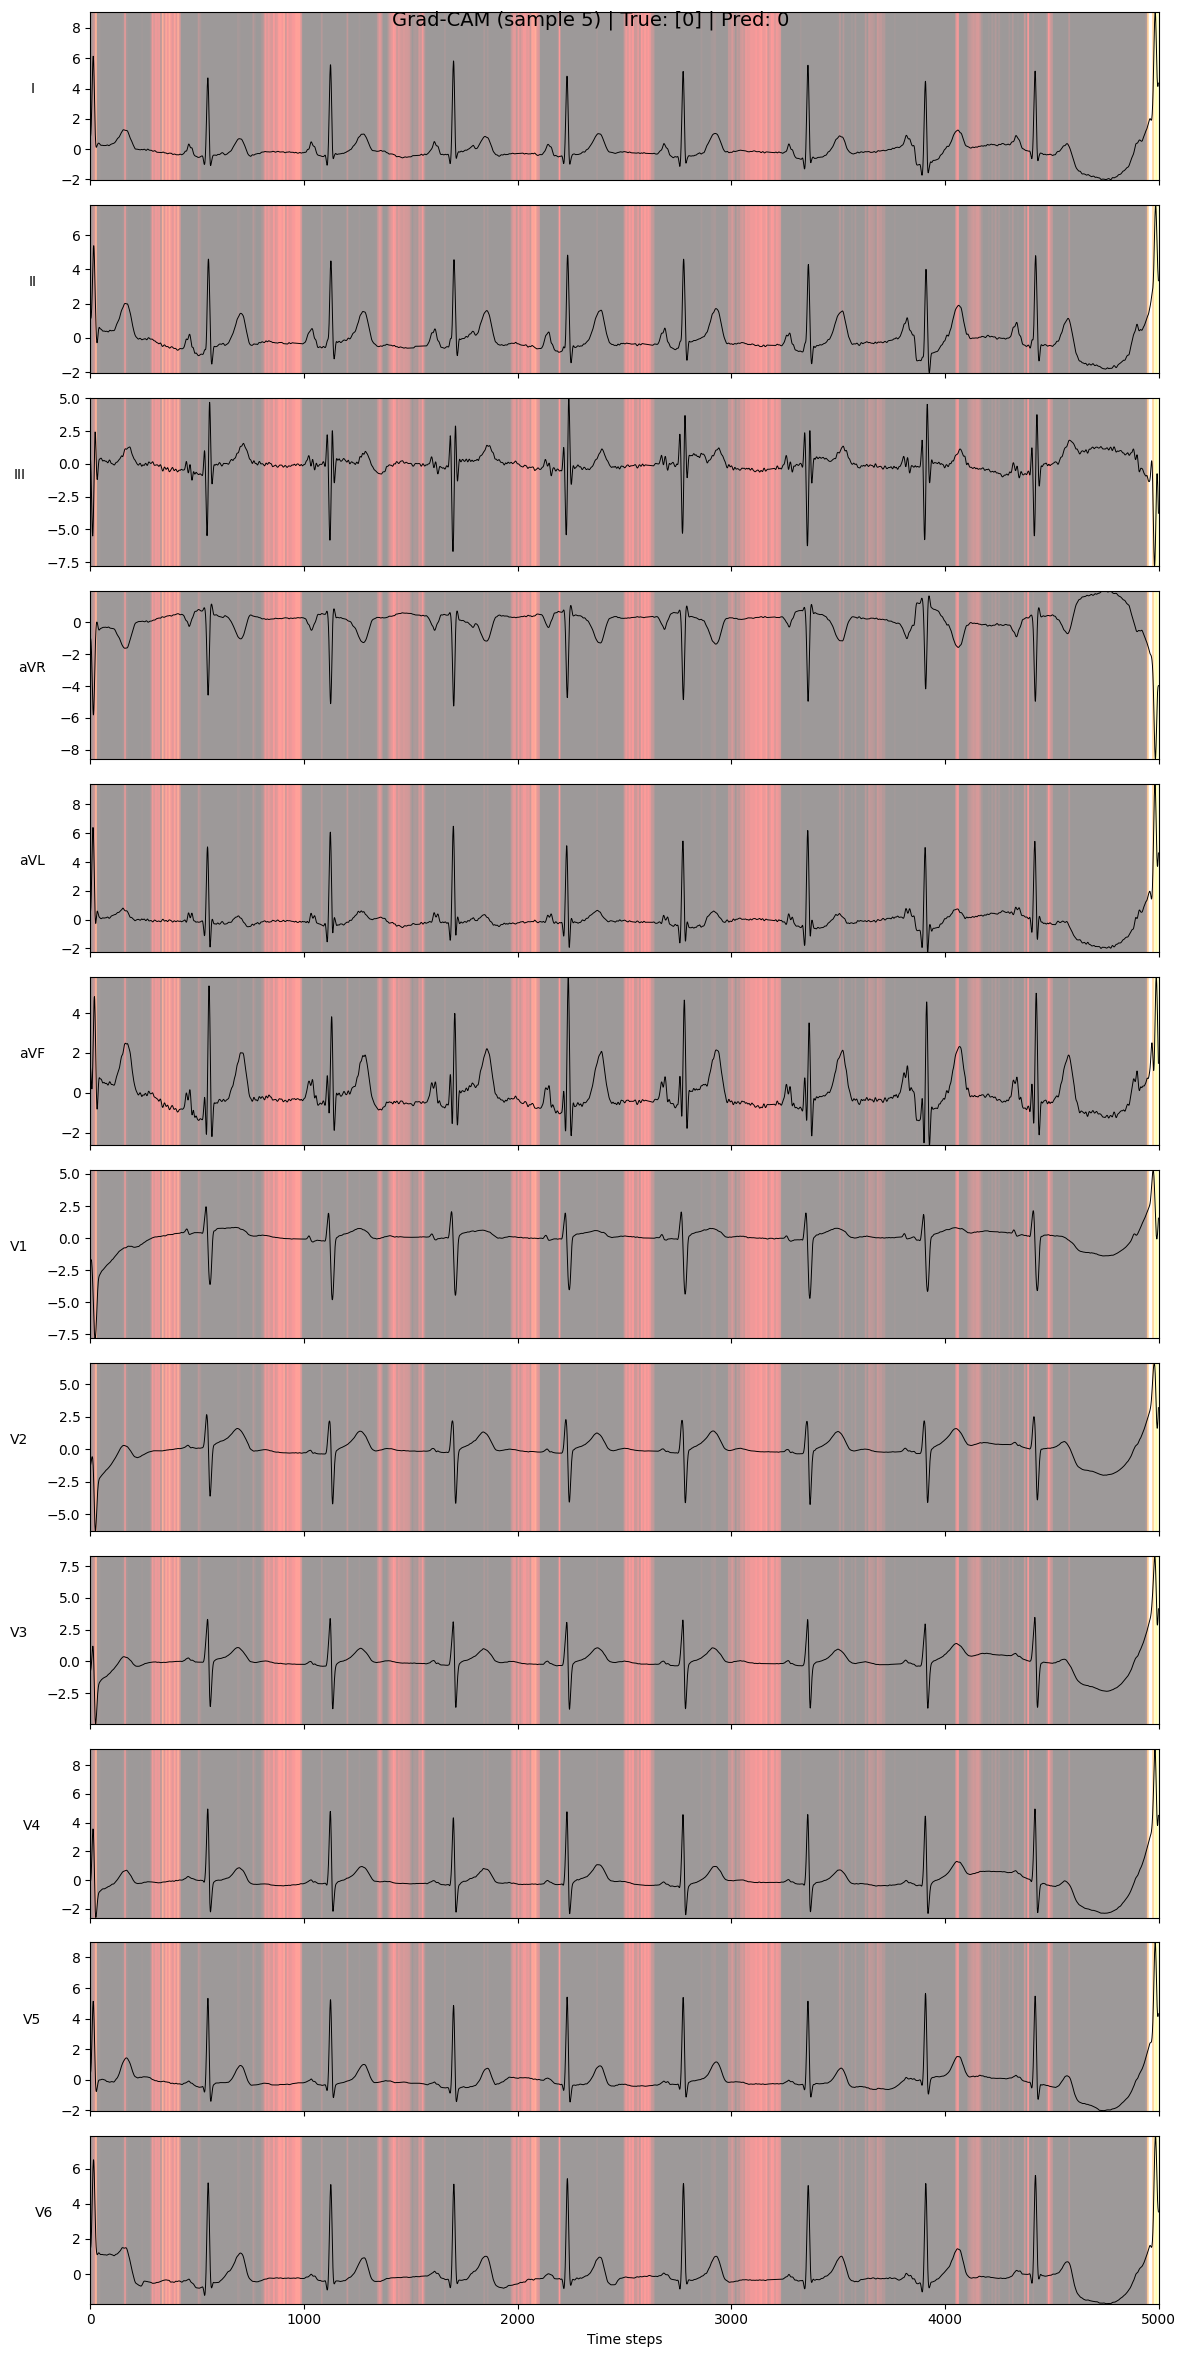

In [8]:
# === Grad-CAM Visualization ===

# T·∫£i dataset test
split_dir = r"E:\NCKH - 2026\ECG Project\data\processed\splits"
X_test = np.load(os.path.join(split_dir, "test_files.npy"), allow_pickle=True)
y_test = np.load(os.path.join(split_dir, "y_test.npy"))

test_dataset = ECGDataset(X_test, y_test)

# Hi·ªÉn th·ªã Grad-CAM cho m·ªôt m·∫´u b·∫•t k·ª≥
visualize_gradcam_multilabel(model, test_dataset, sample_idx=5, target_layer="layer3.conv2")